In [ ]:
# Installations
!pip install -q super-gradients
!pip install -q torch
!pip install -q roboflow
!pip install supervision

# Restart kernel/runtime after installation

In [6]:
# Import the dataset from Roboflow
import roboflow
from roboflow import Roboflow

# Without API Key
# roboflow.login()
# rf = Roboflow()

# With API Key
rf = Roboflow(api_key="VXuKU01F5G92IbaueYM1")
project = rf.workspace("d2r-vmode").project("salvageai")
dataset = project.version(1).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


In [1]:
# Imports
import os
import requests
import torch
import zipfile
import roboflow
import cv2
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train,
    coco_detection_yolo_format_val
)
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import (
   DetectionMetrics_050, # Metrics for detecting objects
   DetectionMetrics_050_095 #
)
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

[2024-03-25 14:58:19] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2024-03-25 14:58:19] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-03-25 14:58:19] INFO - utils.py - NumExpr defaulting to 4 threads.
2024-03-25 14:58:24.952602: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 14:58:24.952701: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 14:58:25.075484: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[WARNING]No module named 'pycocotools'


[2024-03-25 14:58:35] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-03-25 14:58:35] WARNING - export.py - Failed to import pytorch_quantization
[2024-03-25 14:58:35] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [8]:
# Configurations
class config:
    #trainer params
    CHECKPOINT_DIR = 'checkpoints'
    EXPERIMENT_NAME = project.name.lower().replace(" ", "_")
    LOCATION = dataset.location
    CLASSES = sorted(project.classes.keys())
    NUM_CLASSES = len(CLASSES)

    #dataset params
    DEVICES = [0]
    DATA_DIR = LOCATION #parent directory to where data lives
    TRAIN_IMAGES_DIR = 'train/images' #child dir of DATA_DIR where train images are
    TRAIN_LABELS_DIR = 'train/labels' #child dir of DATA_DIR where train labels are

    VAL_IMAGES_DIR = 'valid/images' #child dir of DATA_DIR where validation images are
    VAL_LABELS_DIR = 'valid/labels' #child dir of DATA_DIR where validation labels are

    TEST_IMAGES_DIR = 'test/images' #child dir of DATA_DIR where test images are
    TEST_LABELS_DIR = 'test/labels' #child dir of DATA_DIR where test labels are

    #dataloader params - you can add whatever PyTorch dataloader params you have
    #could be different across train, val, and test
    DATALOADER_PARAMS={
    'batch_size':16,
    'num_workers':4
    }
    MAX_EPOCHS = 500

    # model params
    MODEL_NAME = 'yolo_nas_l' # choose from yolo_nas_s, yolo_nas_m, yolo_nas_l
    PRETRAINED_WEIGHTS = 'coco' #only one option here: coco
#     DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    CONFIDENCE_TRESHOLD = 0.9 # Note, you can set the confidence threshold value as you please.

In [9]:
# Initialize the Trainer
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

[2024-03-25 15:00:01] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 2200/2200 [00:00<00:00, 5471.46it/s]
[2024-03-25 15:00:02] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 1700/1700 [00:00<00:00, 5661.42it/s]
[2024-03-25 15:00:03] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 100/100 [00:00<00:00, 5125.07it/s]


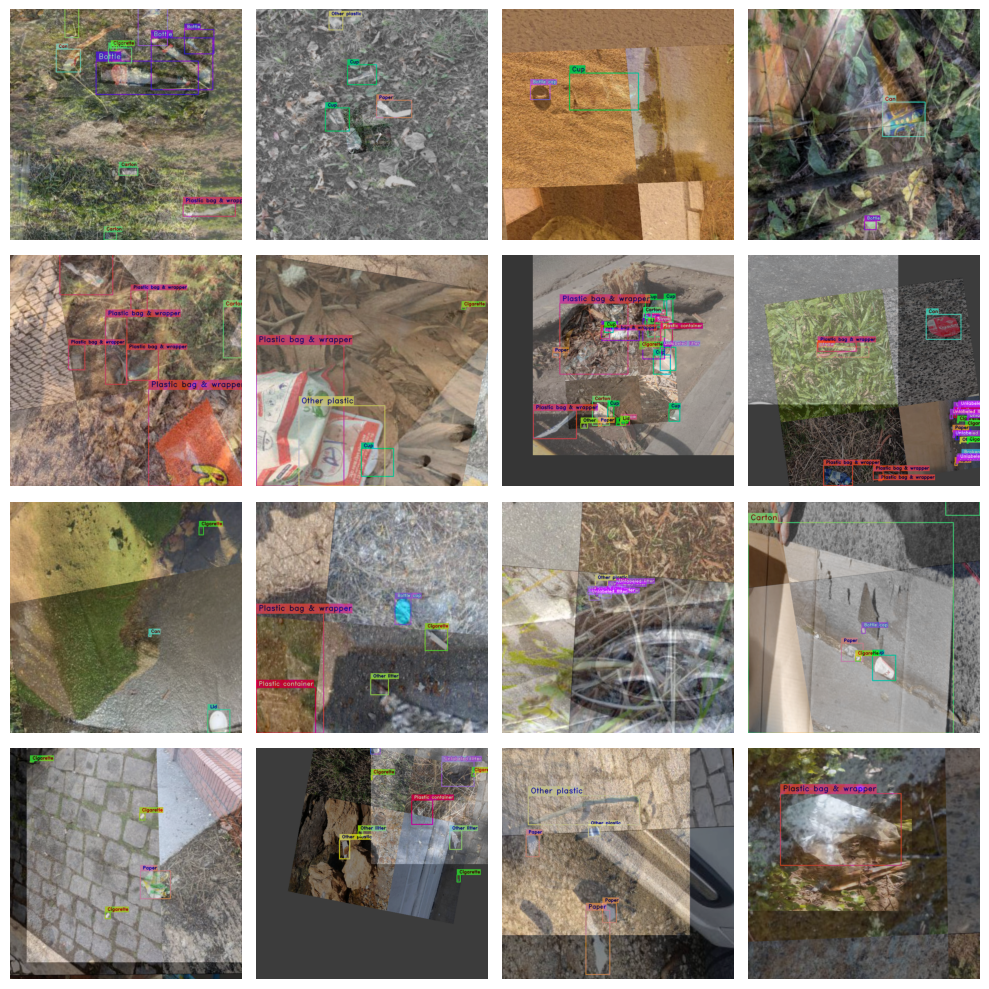

In [10]:
# Load the Datasets and Dataloaders
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

train_data.dataset.plot()

In [11]:
# Instantiate the Model
model = models.get(config.MODEL_NAME,
                  num_classes=config.NUM_CLASSES,
                  pretrained_weights=config.PRETRAINED_WEIGHTS,
                  ).to(config.DEVICES[0])


[2024-03-25 15:00:21] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-03-25 15:00:21] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:00<00:00, 317MB/s] 
[2024-03-25 15:00:22] INFO - checkpoin

In [12]:
# Define metrics and training parameters
train_params = {
   'silent_mode': False,
   "average_best_models":True,
   "warmup_mode": "linear_epoch_step",
   "warmup_initial_lr": 1e-6,
   "lr_warmup_epochs": 3,
   "initial_lr": 5e-4,
   "lr_mode": "cosine",
   "cosine_final_lr_ratio": 0.1,
   "optimizer": "Adam",
   "optimizer_params": {"weight_decay": 0.0001},
   "zero_weight_decay_on_bias_and_bn": True,
   "ema": True,
   "ema_params": {"decay": 0.9, "decay_type": "threshold"},
   "max_epochs": config.MAX_EPOCHS,
   "mixed_precision": True,
   "loss": PPYoloELoss(
       use_static_assigner=False,
       num_classes=config.NUM_CLASSES,
       reg_max=16
   ),
   "valid_metrics_list": [
       DetectionMetrics_050_095(
           score_thres=0.1,
           top_k_predictions=300,
           num_cls=config.NUM_CLASSES,
           normalize_targets=True,
           post_prediction_callback=PPYoloEPostPredictionCallback(
               score_threshold=0.01,
               nms_top_k=1000,
               max_predictions=300,
               nms_threshold=0.7
           )
       )
   ],
   "metric_to_watch": 'mAP@0.50:0.95'
}

In [ ]:
  # Train the model
trainer.train(
   model=model,
   training_params=train_params,
   train_loader=train_data,
   valid_loader=val_data,
)

[2024-03-25 15:00:33] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240325_150033_316733`
[2024-03-25 15:00:33] INFO - sg_trainer.py - Checkpoints directory: checkpoints/salvageai/RUN_20240325_150033_316733
[2024-03-25 15:00:33] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/salvageai/RUN_20240325_150033_316733/console_Mar25_15_00_33.txt


Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
[2024-03-25 15:00:42] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            2200       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         137     

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.78
│   ├── Ppyoloeloss/loss_iou = 0.6421
│   ├── Ppyoloeloss/loss_dfl = 0.6531
│   └── Ppyoloeloss/loss = 4.0752
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.8225
    ├── Ppyoloeloss/loss_iou = 0.4578
    ├── Ppyoloeloss/loss_dfl = 0.52
    ├── Ppyoloeloss/loss = 3.8003
    ├── Precision@0.50:0.95 = 0.0019
    ├── Recall@0.50:0.95 = 0.0
    ├── Map@0.50:0.95 = 0.0001
    ├── F1@0.50:0.95 = 0.0
    └── Best_score_threshold = 0.04



Validating epoch 1: 100%|██████████| 106/106 [00:41<00:00,  2.58it/s]
[2024-03-25 15:07:51] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/salvageai/RUN_20240325_150033_316733/ckpt_best.pth
[2024-03-25 15:07:51] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.023518601432442665


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.7335
│   │   ├── Epoch N-1      = 2.78   (↘ -1.0465)
│   │   └── Best until now = 2.78   (↘ -1.0465)
│   ├── Ppyoloeloss/loss_iou = 0.5911
│   │   ├── Epoch N-1      = 0.6421 (↘ -0.0511)
│   │   └── Best until now = 0.6421 (↘ -0.0511)
│   ├── Ppyoloeloss/loss_dfl = 0.5808
│   │   ├── Epoch N-1      = 0.6531 (↘ -0.0723)
│   │   └── Best until now = 0.6531 (↘ -0.0723)
│   └── Ppyoloeloss/loss = 2.9053
│       ├── Epoch N-1      = 4.0752 (↘ -1.1699)
│       └── Best until now = 4.0752 (↘ -1.1699)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.7752
    │   ├── Epoch N-1      = 2.8225 (↘ -1.0472)
    │   └── Best until now = 2.8225 (↘ -1.0472)
    ├── Ppyoloeloss/loss_iou = 0.457
    │   ├── Epoch N-1      = 0.4578 (↘ -0.0008)
    │   └── Best until now = 0.4578 (↘ -0.0008)
    ├── Ppyoloeloss/loss_dfl = 0.4716
    │   ├── Epoch N-1      = 0.52   (↘ -0.0484)
    │   └── Best until now = 0.52   (↘ -0.0484)
    ├── Ppyoloeloss/los

Validating epoch 2: 100%|██████████| 106/106 [00:41<00:00,  2.56it/s]
[2024-03-25 15:11:23] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/salvageai/RUN_20240325_150033_316733/ckpt_best.pth
[2024-03-25 15:11:23] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.032964371144771576


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.5431
│   │   ├── Epoch N-1      = 1.7335 (↘ -0.1904)
│   │   └── Best until now = 1.7335 (↘ -0.1904)
│   ├── Ppyoloeloss/loss_iou = 0.5771
│   │   ├── Epoch N-1      = 0.5911 (↘ -0.0139)
│   │   └── Best until now = 0.5911 (↘ -0.0139)
│   ├── Ppyoloeloss/loss_dfl = 0.5756
│   │   ├── Epoch N-1      = 0.5808 (↘ -0.0051)
│   │   └── Best until now = 0.5808 (↘ -0.0051)
│   └── Ppyoloeloss/loss = 2.6959
│       ├── Epoch N-1      = 2.9053 (↘ -0.2094)
│       └── Best until now = 2.9053 (↘ -0.2094)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.4989
    │   ├── Epoch N-1      = 1.7752 (↗ 0.7237)
    │   └── Best until now = 1.7752 (↗ 0.7237)
    ├── Ppyoloeloss/loss_iou = 0.4986
    │   ├── Epoch N-1      = 0.457  (↗ 0.0416)
    │   └── Best until now = 0.457  (↗ 0.0416)
    ├── Ppyoloeloss/loss_dfl = 0.5155
    │   ├── Epoch N-1      = 0.4716 (↗ 0.0439)
    │   └── Best until now = 0.4716 (↗ 0.0439)
    ├── Ppyoloeloss/loss = 3

Validating epoch 3: 100%|██████████| 106/106 [00:41<00:00,  2.57it/s]
[2024-03-25 15:14:56] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/salvageai/RUN_20240325_150033_316733/ckpt_best.pth
[2024-03-25 15:14:56] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.0396142415702343


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.5113
│   │   ├── Epoch N-1      = 1.5431 (↘ -0.0319)
│   │   └── Best until now = 1.5431 (↘ -0.0319)
│   ├── Ppyoloeloss/loss_iou = 0.574
│   │   ├── Epoch N-1      = 0.5771 (↘ -0.0032)
│   │   └── Best until now = 0.5771 (↘ -0.0032)
│   ├── Ppyoloeloss/loss_dfl = 0.5878
│   │   ├── Epoch N-1      = 0.5756 (↗ 0.0122)
│   │   └── Best until now = 0.5756 (↗ 0.0122)
│   └── Ppyoloeloss/loss = 2.6731
│       ├── Epoch N-1      = 2.6959 (↘ -0.0228)
│       └── Best until now = 2.6959 (↘ -0.0228)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.7081
    │   ├── Epoch N-1      = 2.4989 (↘ -0.7908)
    │   └── Best until now = 1.7752 (↘ -0.0671)
    ├── Ppyoloeloss/loss_iou = 0.4893
    │   ├── Epoch N-1      = 0.4986 (↘ -0.0093)
    │   └── Best until now = 0.457  (↗ 0.0324)
    ├── Ppyoloeloss/loss_dfl = 0.519
    │   ├── Epoch N-1      = 0.5155 (↗ 0.0036)
    │   └── Best until now = 0.4716 (↗ 0.0475)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 4: 100%|██████████| 106/106 [00:41<00:00,  2.55it/s]
[2024-03-25 15:18:31] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/salvageai/RUN_20240325_150033_316733/ckpt_best.pth
[2024-03-25 15:18:31] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.049758054316043854


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.4828
│   │   ├── Epoch N-1      = 1.5113 (↘ -0.0285)
│   │   └── Best until now = 1.5113 (↘ -0.0285)
│   ├── Ppyoloeloss/loss_iou = 0.5632
│   │   ├── Epoch N-1      = 0.574  (↘ -0.0107)
│   │   └── Best until now = 0.574  (↘ -0.0107)
│   ├── Ppyoloeloss/loss_dfl = 0.5768
│   │   ├── Epoch N-1      = 0.5878 (↘ -0.0111)
│   │   └── Best until now = 0.5756 (↗ 0.0012)
│   └── Ppyoloeloss/loss = 2.6228
│       ├── Epoch N-1      = 2.6731 (↘ -0.0503)
│       └── Best until now = 2.6731 (↘ -0.0503)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.6209
    │   ├── Epoch N-1      = 1.7081 (↘ -0.0872)
    │   └── Best until now = 1.7081 (↘ -0.0872)
    ├── Ppyoloeloss/loss_iou = 0.47
    │   ├── Epoch N-1      = 0.4893 (↘ -0.0193)
    │   └── Best until now = 0.457  (↗ 0.0131)
    ├── Ppyoloeloss/loss_dfl = 0.4984
    │   ├── Epoch N-1      = 0.519  (↘ -0.0206)
    │   └── Best until now = 0.4716 (↗ 0.0268)
    ├── Ppyoloeloss/loss = 

Validating epoch 5: 100%|██████████| 106/106 [00:41<00:00,  2.58it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.4614
│   │   ├── Epoch N-1      = 1.4828 (↘ -0.0214)
│   │   └── Best until now = 1.4828 (↘ -0.0214)
│   ├── Ppyoloeloss/loss_iou = 0.5567
│   │   ├── Epoch N-1      = 0.5632 (↘ -0.0065)
│   │   └── Best until now = 0.5632 (↘ -0.0065)
│   ├── Ppyoloeloss/loss_dfl = 0.5682
│   │   ├── Epoch N-1      = 0.5768 (↘ -0.0086)
│   │   └── Best until now = 0.5756 (↘ -0.0074)
│   └── Ppyoloeloss/loss = 2.5863
│       ├── Epoch N-1      = 2.6228 (↘ -0.0365)
│       └── Best until now = 2.6228 (↘ -0.0365)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.9054
    │   ├── Epoch N-1      = 1.6209 (↗ 0.2846)
    │   └── Best until now = 1.6209 (↗ 0.2846)
    ├── Ppyoloeloss/loss_iou = 0.4795
    │   ├── Epoch N-1      = 0.47   (↗ 0.0095)
    │   └── Best until now = 0.457  (↗ 0.0225)
    ├── Ppyoloeloss/loss_dfl = 0.5089
    │   ├── Epoch N-1      = 0.4984 (↗ 0.0105)
    │   └── Best until now = 0.4716 (↗ 0.0373)
    ├── Ppyoloeloss/loss = 2

Validating epoch 6: 100%|██████████| 106/106 [00:41<00:00,  2.56it/s]
[2024-03-25 15:25:43] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/salvageai/RUN_20240325_150033_316733/ckpt_best.pth
[2024-03-25 15:25:43] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.05301080644130707


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.4376
│   │   ├── Epoch N-1      = 1.4614 (↘ -0.0237)
│   │   └── Best until now = 1.4614 (↘ -0.0237)
│   ├── Ppyoloeloss/loss_iou = 0.5535
│   │   ├── Epoch N-1      = 0.5567 (↘ -0.0032)
│   │   └── Best until now = 0.5567 (↘ -0.0032)
│   ├── Ppyoloeloss/loss_dfl = 0.5637
│   │   ├── Epoch N-1      = 0.5682 (↘ -0.0045)
│   │   └── Best until now = 0.5682 (↘ -0.0045)
│   └── Ppyoloeloss/loss = 2.5549
│       ├── Epoch N-1      = 2.5863 (↘ -0.0314)
│       └── Best until now = 2.5863 (↘ -0.0314)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.6221
    │   ├── Epoch N-1      = 1.9054 (↘ -0.2833)
    │   └── Best until now = 1.6209 (↗ 0.0013)
    ├── Ppyoloeloss/loss_iou = 0.4699
    │   ├── Epoch N-1      = 0.4795 (↘ -0.0096)
    │   └── Best until now = 0.457  (↗ 0.0129)
    ├── Ppyoloeloss/loss_dfl = 0.4979
    │   ├── Epoch N-1      = 0.5089 (↘ -0.011)
    │   └── Best until now = 0.4716 (↗ 0.0263)
    ├── Ppyoloeloss/loss =

Validating epoch 7: 100%|██████████| 106/106 [00:42<00:00,  2.51it/s]
[2024-03-25 15:29:19] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/salvageai/RUN_20240325_150033_316733/ckpt_best.pth
[2024-03-25 15:29:19] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.05852454528212547


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.4277
│   │   ├── Epoch N-1      = 1.4376 (↘ -0.01)
│   │   └── Best until now = 1.4376 (↘ -0.01)
│   ├── Ppyoloeloss/loss_iou = 0.5481
│   │   ├── Epoch N-1      = 0.5535 (↘ -0.0054)
│   │   └── Best until now = 0.5535 (↘ -0.0054)
│   ├── Ppyoloeloss/loss_dfl = 0.564
│   │   ├── Epoch N-1      = 0.5637 (↗ 0.0003)
│   │   └── Best until now = 0.5637 (↗ 0.0003)
│   └── Ppyoloeloss/loss = 2.5398
│       ├── Epoch N-1      = 2.5549 (↘ -0.0151)
│       └── Best until now = 2.5549 (↘ -0.0151)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.6506
    │   ├── Epoch N-1      = 1.6221 (↗ 0.0284)
    │   └── Best until now = 1.6209 (↗ 0.0297)
    ├── Ppyoloeloss/loss_iou = 0.4735
    │   ├── Epoch N-1      = 0.4699 (↗ 0.0036)
    │   └── Best until now = 0.457  (↗ 0.0165)
    ├── Ppyoloeloss/loss_dfl = 0.5039
    │   ├── Epoch N-1      = 0.4979 (↗ 0.0059)
    │   └── Best until now = 0.4716 (↗ 0.0323)
    ├── Ppyoloeloss/loss = 2.628
  

Validating epoch 9: 100%|██████████| 106/106 [00:41<00:00,  2.55it/s]
[2024-03-25 15:36:35] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/salvageai/RUN_20240325_150033_316733/ckpt_best.pth
[2024-03-25 15:36:35] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.07303708791732788


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.4223
│   │   ├── Epoch N-1      = 1.4327 (↘ -0.0104)
│   │   └── Best until now = 1.4277 (↘ -0.0054)
│   ├── Ppyoloeloss/loss_iou = 0.5407
│   │   ├── Epoch N-1      = 0.5412 (↘ -0.0005)
│   │   └── Best until now = 0.5412 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.5524
│   │   ├── Epoch N-1      = 0.5568 (↘ -0.0044)
│   │   └── Best until now = 0.5568 (↘ -0.0044)
│   └── Ppyoloeloss/loss = 2.5154
│       ├── Epoch N-1      = 2.5307 (↘ -0.0153)
│       └── Best until now = 2.5307 (↘ -0.0153)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.7792
    │   ├── Epoch N-1      = 1.6918 (↗ 0.0874)
    │   └── Best until now = 1.6209 (↗ 0.1583)
    ├── Ppyoloeloss/loss_iou = 0.4591
    │   ├── Epoch N-1      = 0.464  (↘ -0.0049)
    │   └── Best until now = 0.457  (↗ 0.0021)
    ├── Ppyoloeloss/loss_dfl = 0.4957
    │   ├── Epoch N-1      = 0.4889 (↗ 0.0068)
    │   └── Best until now = 0.4716 (↗ 0.0241)
    ├── Ppyoloeloss/loss = 

Validating epoch 10: 100%|██████████| 106/106 [00:42<00:00,  2.50it/s]
[2024-03-25 15:40:22] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/salvageai/RUN_20240325_150033_316733/ckpt_best.pth
[2024-03-25 15:40:22] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.07672256231307983


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.4104
│   │   ├── Epoch N-1      = 1.4223 (↘ -0.0119)
│   │   └── Best until now = 1.4223 (↘ -0.0119)
│   ├── Ppyoloeloss/loss_iou = 0.5382
│   │   ├── Epoch N-1      = 0.5407 (↘ -0.0025)
│   │   └── Best until now = 0.5407 (↘ -0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.5546
│   │   ├── Epoch N-1      = 0.5524 (↗ 0.0022)
│   │   └── Best until now = 0.5524 (↗ 0.0022)
│   └── Ppyoloeloss/loss = 2.5032
│       ├── Epoch N-1      = 2.5154 (↘ -0.0122)
│       └── Best until now = 2.5154 (↘ -0.0122)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.561
    │   ├── Epoch N-1      = 1.7792 (↘ -0.2182)
    │   └── Best until now = 1.6209 (↘ -0.0599)
    ├── Ppyoloeloss/loss_iou = 0.4546
    │   ├── Epoch N-1      = 0.4591 (↘ -0.0045)
    │   └── Best until now = 0.457  (↘ -0.0024)
    ├── Ppyoloeloss/loss_dfl = 0.4766
    │   ├── Epoch N-1      = 0.4957 (↘ -0.0191)
    │   └── Best until now = 0.4716 (↗ 0.005)
    ├── Ppyoloeloss/loss =

Validating epoch 11: 100%|██████████| 106/106 [00:42<00:00,  2.52it/s]


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3989
│   │   ├── Epoch N-1      = 1.4104 (↘ -0.0115)
│   │   └── Best until now = 1.4104 (↘ -0.0115)
│   ├── Ppyoloeloss/loss_iou = 0.5382
│   │   ├── Epoch N-1      = 0.5382 (↘ -0.0)
│   │   └── Best until now = 0.5382 (↘ -0.0)
│   ├── Ppyoloeloss/loss_dfl = 0.5475
│   │   ├── Epoch N-1      = 0.5546 (↘ -0.0071)
│   │   └── Best until now = 0.5524 (↘ -0.0049)
│   └── Ppyoloeloss/loss = 2.4846
│       ├── Epoch N-1      = 2.5032 (↘ -0.0186)
│       └── Best until now = 2.5032 (↘ -0.0186)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.622
    │   ├── Epoch N-1      = 1.561  (↗ 0.0611)
    │   └── Best until now = 1.561  (↗ 0.0611)
    ├── Ppyoloeloss/loss_iou = 0.4594
    │   ├── Epoch N-1      = 0.4546 (↗ 0.0048)
    │   └── Best until now = 0.4546 (↗ 0.0048)
    ├── Ppyoloeloss/loss_dfl = 0.4881
    │   ├── Epoch N-1      = 0.4766 (↗ 0.0115)
    │   └── Best until now = 0.4716 (↗ 0.0165)
    ├── Ppyoloeloss/loss = 2.5695


Validating epoch 12: 100%|██████████| 106/106 [00:41<00:00,  2.53it/s]


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3995
│   │   ├── Epoch N-1      = 1.3989 (↗ 0.0006)
│   │   └── Best until now = 1.3989 (↗ 0.0006)
│   ├── Ppyoloeloss/loss_iou = 0.5331
│   │   ├── Epoch N-1      = 0.5382 (↘ -0.0051)
│   │   └── Best until now = 0.5382 (↘ -0.0051)
│   ├── Ppyoloeloss/loss_dfl = 0.5492
│   │   ├── Epoch N-1      = 0.5475 (↗ 0.0017)
│   │   └── Best until now = 0.5475 (↗ 0.0017)
│   └── Ppyoloeloss/loss = 2.4818
│       ├── Epoch N-1      = 2.4846 (↘ -0.0028)
│       └── Best until now = 2.4846 (↘ -0.0028)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5412
    │   ├── Epoch N-1      = 1.622  (↘ -0.0808)
    │   └── Best until now = 1.561  (↘ -0.0197)
    ├── Ppyoloeloss/loss_iou = 0.4812
    │   ├── Epoch N-1      = 0.4594 (↗ 0.0219)
    │   └── Best until now = 0.4546 (↗ 0.0266)
    ├── Ppyoloeloss/loss_dfl = 0.4981
    │   ├── Epoch N-1      = 0.4881 (↗ 0.01)
    │   └── Best until now = 0.4716 (↗ 0.0265)
    ├── Ppyoloeloss/loss = 2.52

Validating epoch 13: 100%|██████████| 106/106 [00:41<00:00,  2.55it/s]


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3939
│   │   ├── Epoch N-1      = 1.3995 (↘ -0.0056)
│   │   └── Best until now = 1.3989 (↘ -0.005)
│   ├── Ppyoloeloss/loss_iou = 0.5362
│   │   ├── Epoch N-1      = 0.5331 (↗ 0.0031)
│   │   └── Best until now = 0.5331 (↗ 0.0031)
│   ├── Ppyoloeloss/loss_dfl = 0.5487
│   │   ├── Epoch N-1      = 0.5492 (↘ -0.0005)
│   │   └── Best until now = 0.5475 (↗ 0.0012)
│   └── Ppyoloeloss/loss = 2.4788
│       ├── Epoch N-1      = 2.4818 (↘ -0.003)
│       └── Best until now = 2.4818 (↘ -0.003)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5061
    │   ├── Epoch N-1      = 1.5412 (↘ -0.0352)
    │   └── Best until now = 1.5412 (↘ -0.0352)
    ├── Ppyoloeloss/loss_iou = 0.4619
    │   ├── Epoch N-1      = 0.4812 (↘ -0.0193)
    │   └── Best until now = 0.4546 (↗ 0.0074)
    ├── Ppyoloeloss/loss_dfl = 0.4872
    │   ├── Epoch N-1      = 0.4981 (↘ -0.0109)
    │   └── Best until now = 0.4716 (↗ 0.0156)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 14: 100%|██████████| 106/106 [00:41<00:00,  2.55it/s]


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3817
│   │   ├── Epoch N-1      = 1.3939 (↘ -0.0122)
│   │   └── Best until now = 1.3939 (↘ -0.0122)
│   ├── Ppyoloeloss/loss_iou = 0.5331
│   │   ├── Epoch N-1      = 0.5362 (↘ -0.0031)
│   │   └── Best until now = 0.5331 (↗ 0.0)
│   ├── Ppyoloeloss/loss_dfl = 0.5426
│   │   ├── Epoch N-1      = 0.5487 (↘ -0.0061)
│   │   └── Best until now = 0.5475 (↘ -0.0049)
│   └── Ppyoloeloss/loss = 2.4575
│       ├── Epoch N-1      = 2.4788 (↘ -0.0214)
│       └── Best until now = 2.4788 (↘ -0.0214)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.9584
    │   ├── Epoch N-1      = 1.5061 (↗ 0.4523)
    │   └── Best until now = 1.5061 (↗ 0.4523)
    ├── Ppyoloeloss/loss_iou = 0.4674
    │   ├── Epoch N-1      = 0.4619 (↗ 0.0054)
    │   └── Best until now = 0.4546 (↗ 0.0128)
    ├── Ppyoloeloss/loss_dfl = 0.4904
    │   ├── Epoch N-1      = 0.4872 (↗ 0.0033)
    │   └── Best until now = 0.4716 (↗ 0.0188)
    ├── Ppyoloeloss/loss = 2.91

Validating epoch 15: 100%|██████████| 106/106 [00:41<00:00,  2.53it/s]
[2024-03-25 15:58:42] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/salvageai/RUN_20240325_150033_316733/ckpt_best.pth
[2024-03-25 15:58:42] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.0797593891620636


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3966
│   │   ├── Epoch N-1      = 1.3817 (↗ 0.0149)
│   │   └── Best until now = 1.3817 (↗ 0.0149)
│   ├── Ppyoloeloss/loss_iou = 0.528
│   │   ├── Epoch N-1      = 0.5331 (↘ -0.0052)
│   │   └── Best until now = 0.5331 (↘ -0.0051)
│   ├── Ppyoloeloss/loss_dfl = 0.5424
│   │   ├── Epoch N-1      = 0.5426 (↘ -0.0003)
│   │   └── Best until now = 0.5426 (↘ -0.0003)
│   └── Ppyoloeloss/loss = 2.4669
│       ├── Epoch N-1      = 2.4575 (↗ 0.0095)
│       └── Best until now = 2.4575 (↗ 0.0095)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4718
    │   ├── Epoch N-1      = 1.9584 (↘ -0.4866)
    │   └── Best until now = 1.5061 (↘ -0.0343)
    ├── Ppyoloeloss/loss_iou = 0.4621
    │   ├── Epoch N-1      = 0.4674 (↘ -0.0053)
    │   └── Best until now = 0.4546 (↗ 0.0075)
    ├── Ppyoloeloss/loss_dfl = 0.4877
    │   ├── Epoch N-1      = 0.4904 (↘ -0.0028)
    │   └── Best until now = 0.4716 (↗ 0.0161)
    ├── Ppyoloeloss/loss = 2

Validating epoch 16: 100%|██████████| 106/106 [00:41<00:00,  2.53it/s]
[2024-03-25 16:02:24] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/salvageai/RUN_20240325_150033_316733/ckpt_best.pth
[2024-03-25 16:02:24] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.08053327351808548


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3827
│   │   ├── Epoch N-1      = 1.3966 (↘ -0.0139)
│   │   └── Best until now = 1.3817 (↗ 0.001)
│   ├── Ppyoloeloss/loss_iou = 0.5331
│   │   ├── Epoch N-1      = 0.528  (↗ 0.0052)
│   │   └── Best until now = 0.528  (↗ 0.0052)
│   ├── Ppyoloeloss/loss_dfl = 0.5458
│   │   ├── Epoch N-1      = 0.5424 (↗ 0.0034)
│   │   └── Best until now = 0.5424 (↗ 0.0034)
│   └── Ppyoloeloss/loss = 2.4616
│       ├── Epoch N-1      = 2.4669 (↘ -0.0054)
│       └── Best until now = 2.4575 (↗ 0.0041)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5721
    │   ├── Epoch N-1      = 1.4718 (↗ 0.1003)
    │   └── Best until now = 1.4718 (↗ 0.1003)
    ├── Ppyoloeloss/loss_iou = 0.4746
    │   ├── Epoch N-1      = 0.4621 (↗ 0.0125)
    │   └── Best until now = 0.4546 (↗ 0.02)
    ├── Ppyoloeloss/loss_dfl = 0.4916
    │   ├── Epoch N-1      = 0.4877 (↗ 0.004)
    │   └── Best until now = 0.4716 (↗ 0.02)
    ├── Ppyoloeloss/loss = 2.5383
    │

Validating epoch 17: 100%|██████████| 106/106 [00:41<00:00,  2.53it/s]
[2024-03-25 16:06:01] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/salvageai/RUN_20240325_150033_316733/ckpt_best.pth
[2024-03-25 16:06:01] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.08107853680849075


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.382
│   │   ├── Epoch N-1      = 1.3827 (↘ -0.0007)
│   │   └── Best until now = 1.3817 (↗ 0.0003)
│   ├── Ppyoloeloss/loss_iou = 0.5288
│   │   ├── Epoch N-1      = 0.5331 (↘ -0.0043)
│   │   └── Best until now = 0.528  (↗ 0.0009)
│   ├── Ppyoloeloss/loss_dfl = 0.5407
│   │   ├── Epoch N-1      = 0.5458 (↘ -0.0051)
│   │   └── Best until now = 0.5424 (↘ -0.0017)
│   └── Ppyoloeloss/loss = 2.4515
│       ├── Epoch N-1      = 2.4616 (↘ -0.0101)
│       └── Best until now = 2.4575 (↘ -0.006)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5932
    │   ├── Epoch N-1      = 1.5721 (↗ 0.0211)
    │   └── Best until now = 1.4718 (↗ 0.1214)
    ├── Ppyoloeloss/loss_iou = 0.4736
    │   ├── Epoch N-1      = 0.4746 (↘ -0.001)
    │   └── Best until now = 0.4546 (↗ 0.019)
    ├── Ppyoloeloss/loss_dfl = 0.4911
    │   ├── Epoch N-1      = 0.4916 (↘ -0.0005)
    │   └── Best until now = 0.4716 (↗ 0.0195)
    ├── Ppyoloeloss/loss = 2.55

Validating epoch 18: 100%|██████████| 106/106 [00:42<00:00,  2.52it/s]


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3786
│   │   ├── Epoch N-1      = 1.382  (↘ -0.0034)
│   │   └── Best until now = 1.3817 (↘ -0.0031)
│   ├── Ppyoloeloss/loss_iou = 0.534
│   │   ├── Epoch N-1      = 0.5288 (↗ 0.0052)
│   │   └── Best until now = 0.528  (↗ 0.0061)
│   ├── Ppyoloeloss/loss_dfl = 0.5422
│   │   ├── Epoch N-1      = 0.5407 (↗ 0.0016)
│   │   └── Best until now = 0.5407 (↗ 0.0016)
│   └── Ppyoloeloss/loss = 2.4549
│       ├── Epoch N-1      = 2.4515 (↗ 0.0034)
│       └── Best until now = 2.4515 (↗ 0.0034)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.6974
    │   ├── Epoch N-1      = 1.5932 (↗ 0.1042)
    │   └── Best until now = 1.4718 (↗ 0.2256)
    ├── Ppyoloeloss/loss_iou = 0.4598
    │   ├── Epoch N-1      = 0.4736 (↘ -0.0138)
    │   └── Best until now = 0.4546 (↗ 0.0052)
    ├── Ppyoloeloss/loss_dfl = 0.479
    │   ├── Epoch N-1      = 0.4911 (↘ -0.0121)
    │   └── Best until now = 0.4716 (↗ 0.0074)
    ├── Ppyoloeloss/loss = 2.6362

Validating epoch 19: 100%|██████████| 106/106 [00:42<00:00,  2.52it/s]


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3731
│   │   ├── Epoch N-1      = 1.3786 (↘ -0.0055)
│   │   └── Best until now = 1.3786 (↘ -0.0055)
│   ├── Ppyoloeloss/loss_iou = 0.522
│   │   ├── Epoch N-1      = 0.534  (↘ -0.012)
│   │   └── Best until now = 0.528  (↘ -0.006)
│   ├── Ppyoloeloss/loss_dfl = 0.5374
│   │   ├── Epoch N-1      = 0.5422 (↘ -0.0048)
│   │   └── Best until now = 0.5407 (↘ -0.0032)
│   └── Ppyoloeloss/loss = 2.4325
│       ├── Epoch N-1      = 2.4549 (↘ -0.0223)
│       └── Best until now = 2.4515 (↘ -0.019)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.6865
    │   ├── Epoch N-1      = 1.6974 (↘ -0.0109)
    │   └── Best until now = 1.4718 (↗ 0.2147)
    ├── Ppyoloeloss/loss_iou = 0.4577
    │   ├── Epoch N-1      = 0.4598 (↘ -0.0021)
    │   └── Best until now = 0.4546 (↗ 0.0032)
    ├── Ppyoloeloss/loss_dfl = 0.4862
    │   ├── Epoch N-1      = 0.479  (↗ 0.0072)
    │   └── Best until now = 0.4716 (↗ 0.0146)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 20: 100%|██████████| 106/106 [00:41<00:00,  2.54it/s]


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3714
│   │   ├── Epoch N-1      = 1.3731 (↘ -0.0017)
│   │   └── Best until now = 1.3731 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_iou = 0.5269
│   │   ├── Epoch N-1      = 0.522  (↗ 0.0049)
│   │   └── Best until now = 0.522  (↗ 0.0049)
│   ├── Ppyoloeloss/loss_dfl = 0.5428
│   │   ├── Epoch N-1      = 0.5374 (↗ 0.0054)
│   │   └── Best until now = 0.5374 (↗ 0.0054)
│   └── Ppyoloeloss/loss = 2.4411
│       ├── Epoch N-1      = 2.4325 (↗ 0.0086)
│       └── Best until now = 2.4325 (↗ 0.0086)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.593
    │   ├── Epoch N-1      = 1.6865 (↘ -0.0935)
    │   └── Best until now = 1.4718 (↗ 0.1212)
    ├── Ppyoloeloss/loss_iou = 0.4554
    │   ├── Epoch N-1      = 0.4577 (↘ -0.0023)
    │   └── Best until now = 0.4546 (↗ 0.0008)
    ├── Ppyoloeloss/loss_dfl = 0.4824
    │   ├── Epoch N-1      = 0.4862 (↘ -0.0038)
    │   └── Best until now = 0.4716 (↗ 0.0108)
    ├── Ppyoloeloss/loss = 2.53

Validating epoch 21: 100%|██████████| 106/106 [00:41<00:00,  2.54it/s]


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3627
│   │   ├── Epoch N-1      = 1.3714 (↘ -0.0087)
│   │   └── Best until now = 1.3714 (↘ -0.0087)
│   ├── Ppyoloeloss/loss_iou = 0.5256
│   │   ├── Epoch N-1      = 0.5269 (↘ -0.0013)
│   │   └── Best until now = 0.522  (↗ 0.0036)
│   ├── Ppyoloeloss/loss_dfl = 0.5371
│   │   ├── Epoch N-1      = 0.5428 (↘ -0.0057)
│   │   └── Best until now = 0.5374 (↘ -0.0003)
│   └── Ppyoloeloss/loss = 2.4254
│       ├── Epoch N-1      = 2.4411 (↘ -0.0157)
│       └── Best until now = 2.4325 (↘ -0.0071)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.6962
    │   ├── Epoch N-1      = 1.593  (↗ 0.1032)
    │   └── Best until now = 1.4718 (↗ 0.2245)
    ├── Ppyoloeloss/loss_iou = 0.4671
    │   ├── Epoch N-1      = 0.4554 (↗ 0.0117)
    │   └── Best until now = 0.4546 (↗ 0.0125)
    ├── Ppyoloeloss/loss_dfl = 0.4862
    │   ├── Epoch N-1      = 0.4824 (↗ 0.0038)
    │   └── Best until now = 0.4716 (↗ 0.0147)
    ├── Ppyoloeloss/loss = 2

Validating epoch 22: 100%|██████████| 106/106 [00:41<00:00,  2.53it/s]


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3575
│   │   ├── Epoch N-1      = 1.3627 (↘ -0.0052)
│   │   └── Best until now = 1.3627 (↘ -0.0052)
│   ├── Ppyoloeloss/loss_iou = 0.5294
│   │   ├── Epoch N-1      = 0.5256 (↗ 0.0038)
│   │   └── Best until now = 0.522  (↗ 0.0074)
│   ├── Ppyoloeloss/loss_dfl = 0.5455
│   │   ├── Epoch N-1      = 0.5371 (↗ 0.0084)
│   │   └── Best until now = 0.5371 (↗ 0.0084)
│   └── Ppyoloeloss/loss = 2.4323
│       ├── Epoch N-1      = 2.4254 (↗ 0.0069)
│       └── Best until now = 2.4254 (↗ 0.0069)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5566
    │   ├── Epoch N-1      = 1.6962 (↘ -0.1397)
    │   └── Best until now = 1.4718 (↗ 0.0848)
    ├── Ppyoloeloss/loss_iou = 0.4751
    │   ├── Epoch N-1      = 0.4671 (↗ 0.008)
    │   └── Best until now = 0.4546 (↗ 0.0205)
    ├── Ppyoloeloss/loss_dfl = 0.4911
    │   ├── Epoch N-1      = 0.4862 (↗ 0.0048)
    │   └── Best until now = 0.4716 (↗ 0.0195)
    ├── Ppyoloeloss/loss = 2.5227

Validating epoch 23: 100%|██████████| 106/106 [00:41<00:00,  2.55it/s]
[2024-03-25 16:27:58] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/salvageai/RUN_20240325_150033_316733/ckpt_best.pth
[2024-03-25 16:27:58] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.08214620500802994


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3496
│   │   ├── Epoch N-1      = 1.3575 (↘ -0.0079)
│   │   └── Best until now = 1.3575 (↘ -0.0079)
│   ├── Ppyoloeloss/loss_iou = 0.5224
│   │   ├── Epoch N-1      = 0.5294 (↘ -0.0069)
│   │   └── Best until now = 0.522  (↗ 0.0004)
│   ├── Ppyoloeloss/loss_dfl = 0.5348
│   │   ├── Epoch N-1      = 0.5455 (↘ -0.0106)
│   │   └── Best until now = 0.5371 (↘ -0.0023)
│   └── Ppyoloeloss/loss = 2.4068
│       ├── Epoch N-1      = 2.4323 (↘ -0.0255)
│       └── Best until now = 2.4254 (↘ -0.0186)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.537
    │   ├── Epoch N-1      = 1.5566 (↘ -0.0196)
    │   └── Best until now = 1.4718 (↗ 0.0652)
    ├── Ppyoloeloss/loss_iou = 0.4639
    │   ├── Epoch N-1      = 0.4751 (↘ -0.0112)
    │   └── Best until now = 0.4546 (↗ 0.0094)
    ├── Ppyoloeloss/loss_dfl = 0.4835
    │   ├── Epoch N-1      = 0.4911 (↘ -0.0076)
    │   └── Best until now = 0.4716 (↗ 0.0119)
    ├── Ppyoloeloss/loss =

Validating epoch 24: 100%|██████████| 106/106 [00:41<00:00,  2.55it/s]


In [ ]:
print("Wind this up, ma")

In [ ]:
# Get the best trained model
path = "/content/checkpoints/salvageai/RUN_20240129_132958_487773/ckpt_best.pth"
best_model = models.get(config.MODEL_NAME,
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path=path)

In [ ]:
#  Evaluate the best Model
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050_095(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=config.NUM_CLASSES,
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,                                                                              nms_threshold=0.7)
                                                  ))

In [ ]:
# Predicting with the best model
best_model.predict("https://media-cdn-v2.laodong.vn/storage/newsportal/2018/9/28/633373/9-1_Opt.jpg", conf=config.CONFIDENCE_TRESHOLD).show()

In [ ]:
dir(best_model)

In [ ]:
best_model.export("/content/model/final_yolonas_trained.trt",engine="tensorrt")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')